# House Prices - Linear model

Welcome! Let's do some regression.

TOC:
1. [Problem Framing](#t1.)
2. [Assess Data Quality & Missing Values](#t2.)
3. [Exploratory Data Analysis](#t3.)
4. [Feature Engineering](#t4.)
5. [Shortlisting Promising ML Models](#t5.)
6. [Fine-Tune the System](#t6.)
7. [Presenting the Solution](#t7.)

References:
    * https://www.kaggle.com/apapiu/regularized-linear-models
    * https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing

<a id="t1."></a>
## 1. Problem Framing

### Problem Definition

This is a standard supervised regression task. Whit 79 explanatory variables describing most aspects of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Goals: 
* Do a comprehensive data analysis along with visualizations.
* Learn/review/explain different regression algorithms and its hyperparameters.
* Create models that are well equipped to predict better sale price of the the house.

### The Data

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

All the different variables come described at the file data_description.txt, said that, we have to have in mind that we need to focus on the target variable, which is SalePrice.

### Preparing the tools

In [1]:
#basic libraries
import sys
import numpy as np
import pandas as pd
import os
import warnings

#seed the project
np.random.seed(64)

#ploting libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (16,8)
from scipy import stats
import missingno
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='pastel', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("ignore")

print("Set up completed")

Set up completed


### Load the Data

In [2]:
# Import train and test data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
# Print the first rows of the training data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Print the first rows of the test data
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print (f"Train has {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print (f"Test has {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


<a id="t2."></a>
## 2. Data Quality & Missing Values Assessment

### Data Types
We can see our dataset consist on different types of data. As we continue to analyze it, we'll find features which are numerical and should actually be categorial.

In [6]:
# Different data types in the dataset
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

### Missing Values

As you can see we have some missing data, let's have a look how many we have for each column at the train_df

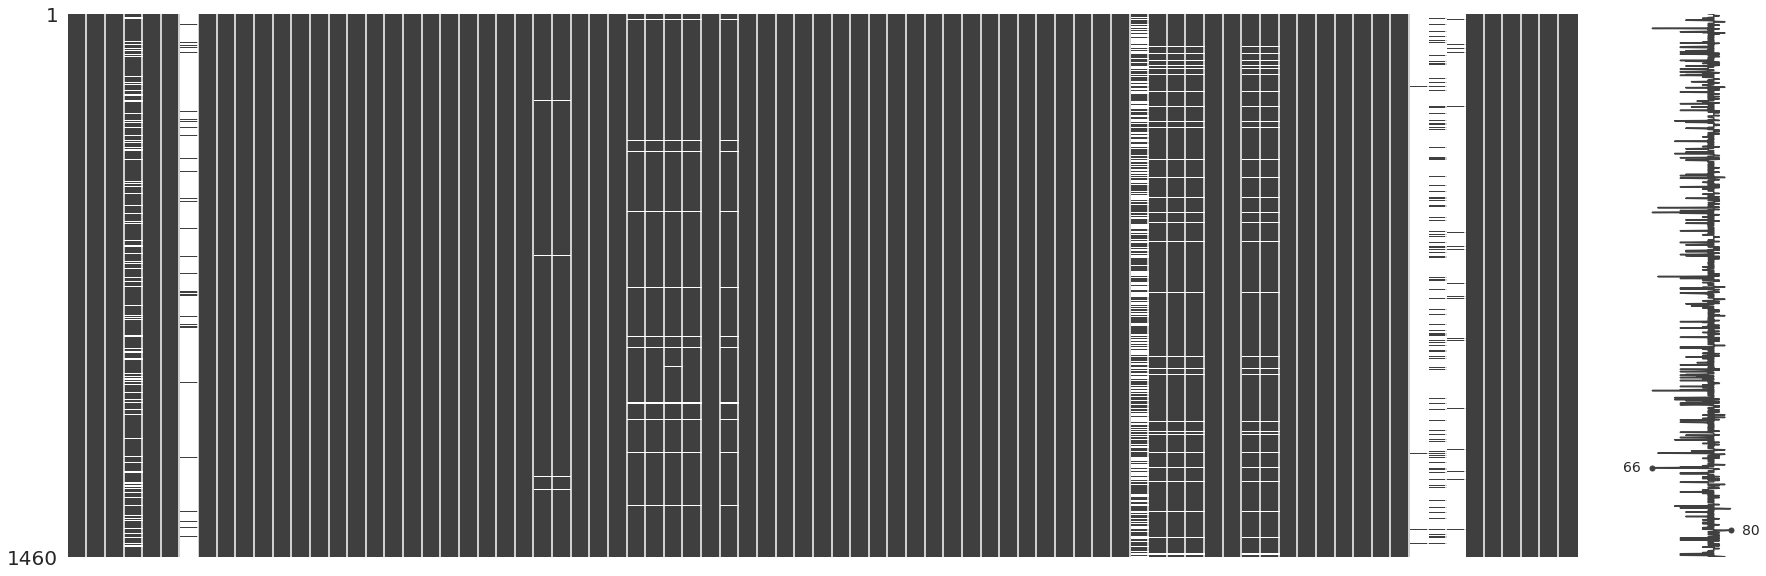

In [7]:
# Plot graphic of missing values
missingno.matrix(train_df, figsize = (30,10));

In [8]:
# We need to see the amount of missing values present in each column.
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train_df)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


It is important to check which columns contain empty values, as most ML models don't work when these are present. In this case, we can see that there are some values with a great amount of missing values, such as PoolQc, MiscFeature, Alley, Fence and FireplaceQu. 

As we said, to be able to continue with our analysis we can't have any missing value, so what we will do is:
* We will drop all columns where the data missing ratio > 50%. We could observe below that "Alley", "Fence", "MiscFeature", "PoolQC" are probaly the 5 first columns we will remove. Also, "LotFrontage" could be the next column that we have to consider.

* Dealing with the numerical missing data by replacing column's mean value, and the object columns will be considered in the next section.

Before continuing, we will how many missing values are found in the test dataset, as we should make the same changes in both.

In [9]:
missing_percentage(test_df).head(10)

,Total,Percent
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageYrBlt,78,5.35
GarageQual,78,5.35
GarageFinish,78,5.35
GarageCond,78,5.35


We can see that the missing values are very similar in both datasets. We will remove 4 columns in both datasets. After exploring our data, we will deal with these.

<a id="t2."></a>
## 3. Exploration Data Analysis

### Exploration of our Target Feature: SalePrice

#### Distribution

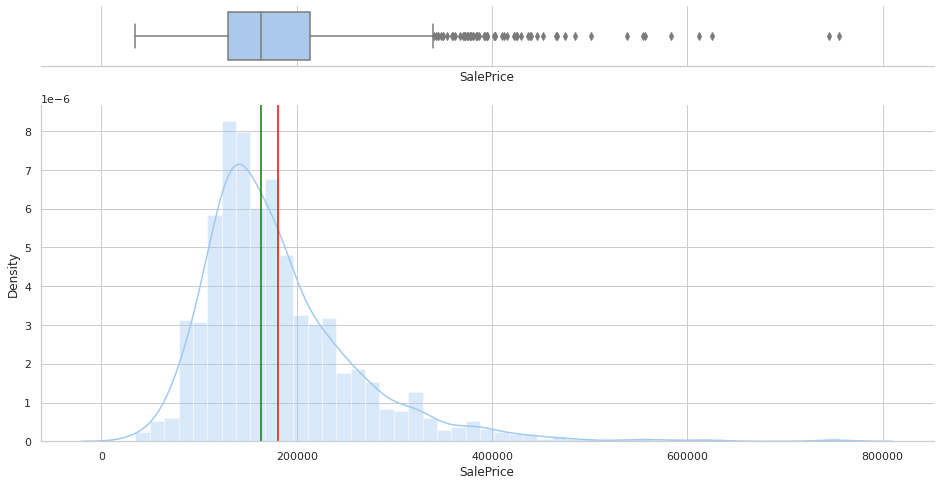

Skewness: 1.882876
Kurtosis: 6.536282


In [10]:
x = train_df['SalePrice']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

From these charts we can learn a lot about our target variable.
* Our target variable, SalePrice is not normally distributed
* Our target variable is right-skewed (can be fixed with different types of transformation)
* There are multiple outliers in the variable

Machine learning algorithms only work properly on normal distribution data, so we want to transform our target feature so that is as "normal" as possible. The simplest wat to correct the distribution is by taking the logarithm of the value.

Let's check a simplest way to correct the distribution of SalePrice by taking logarithm of the value.

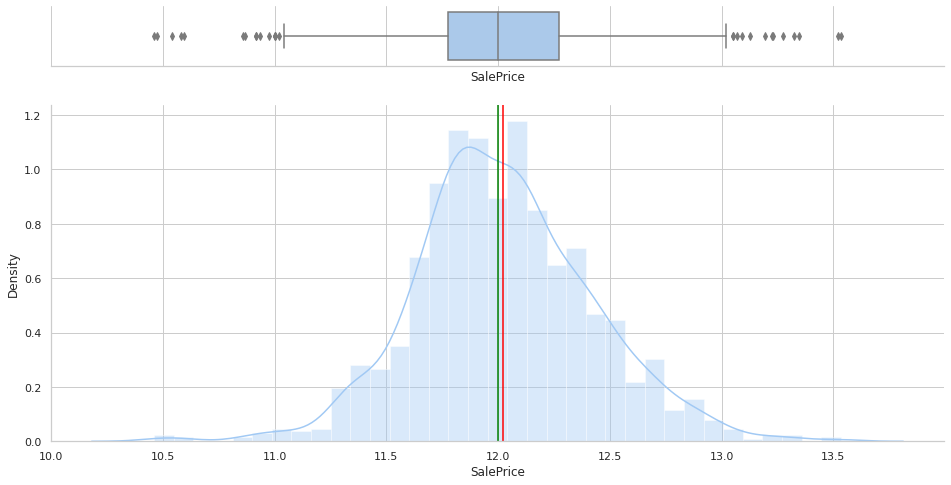

In [11]:
x = np.log(train_df['SalePrice'])
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

This is much better. It's not perfect, but using a logarithm conversion is one of the simpliest ways to obtain a normal distribution function, so we will apply this in the next section to train the model.

### Key Variable Correlations

The correlation matrix is the best way to see all the numerical correlation between features. Let's see which are the feature that correlate most with our target variable.

In [12]:
## Getting the correlation of all the features with target variable. 
(train_df.corr('pearson'))['SalePrice'].sort_values(ascending = False)[1:].head()

OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

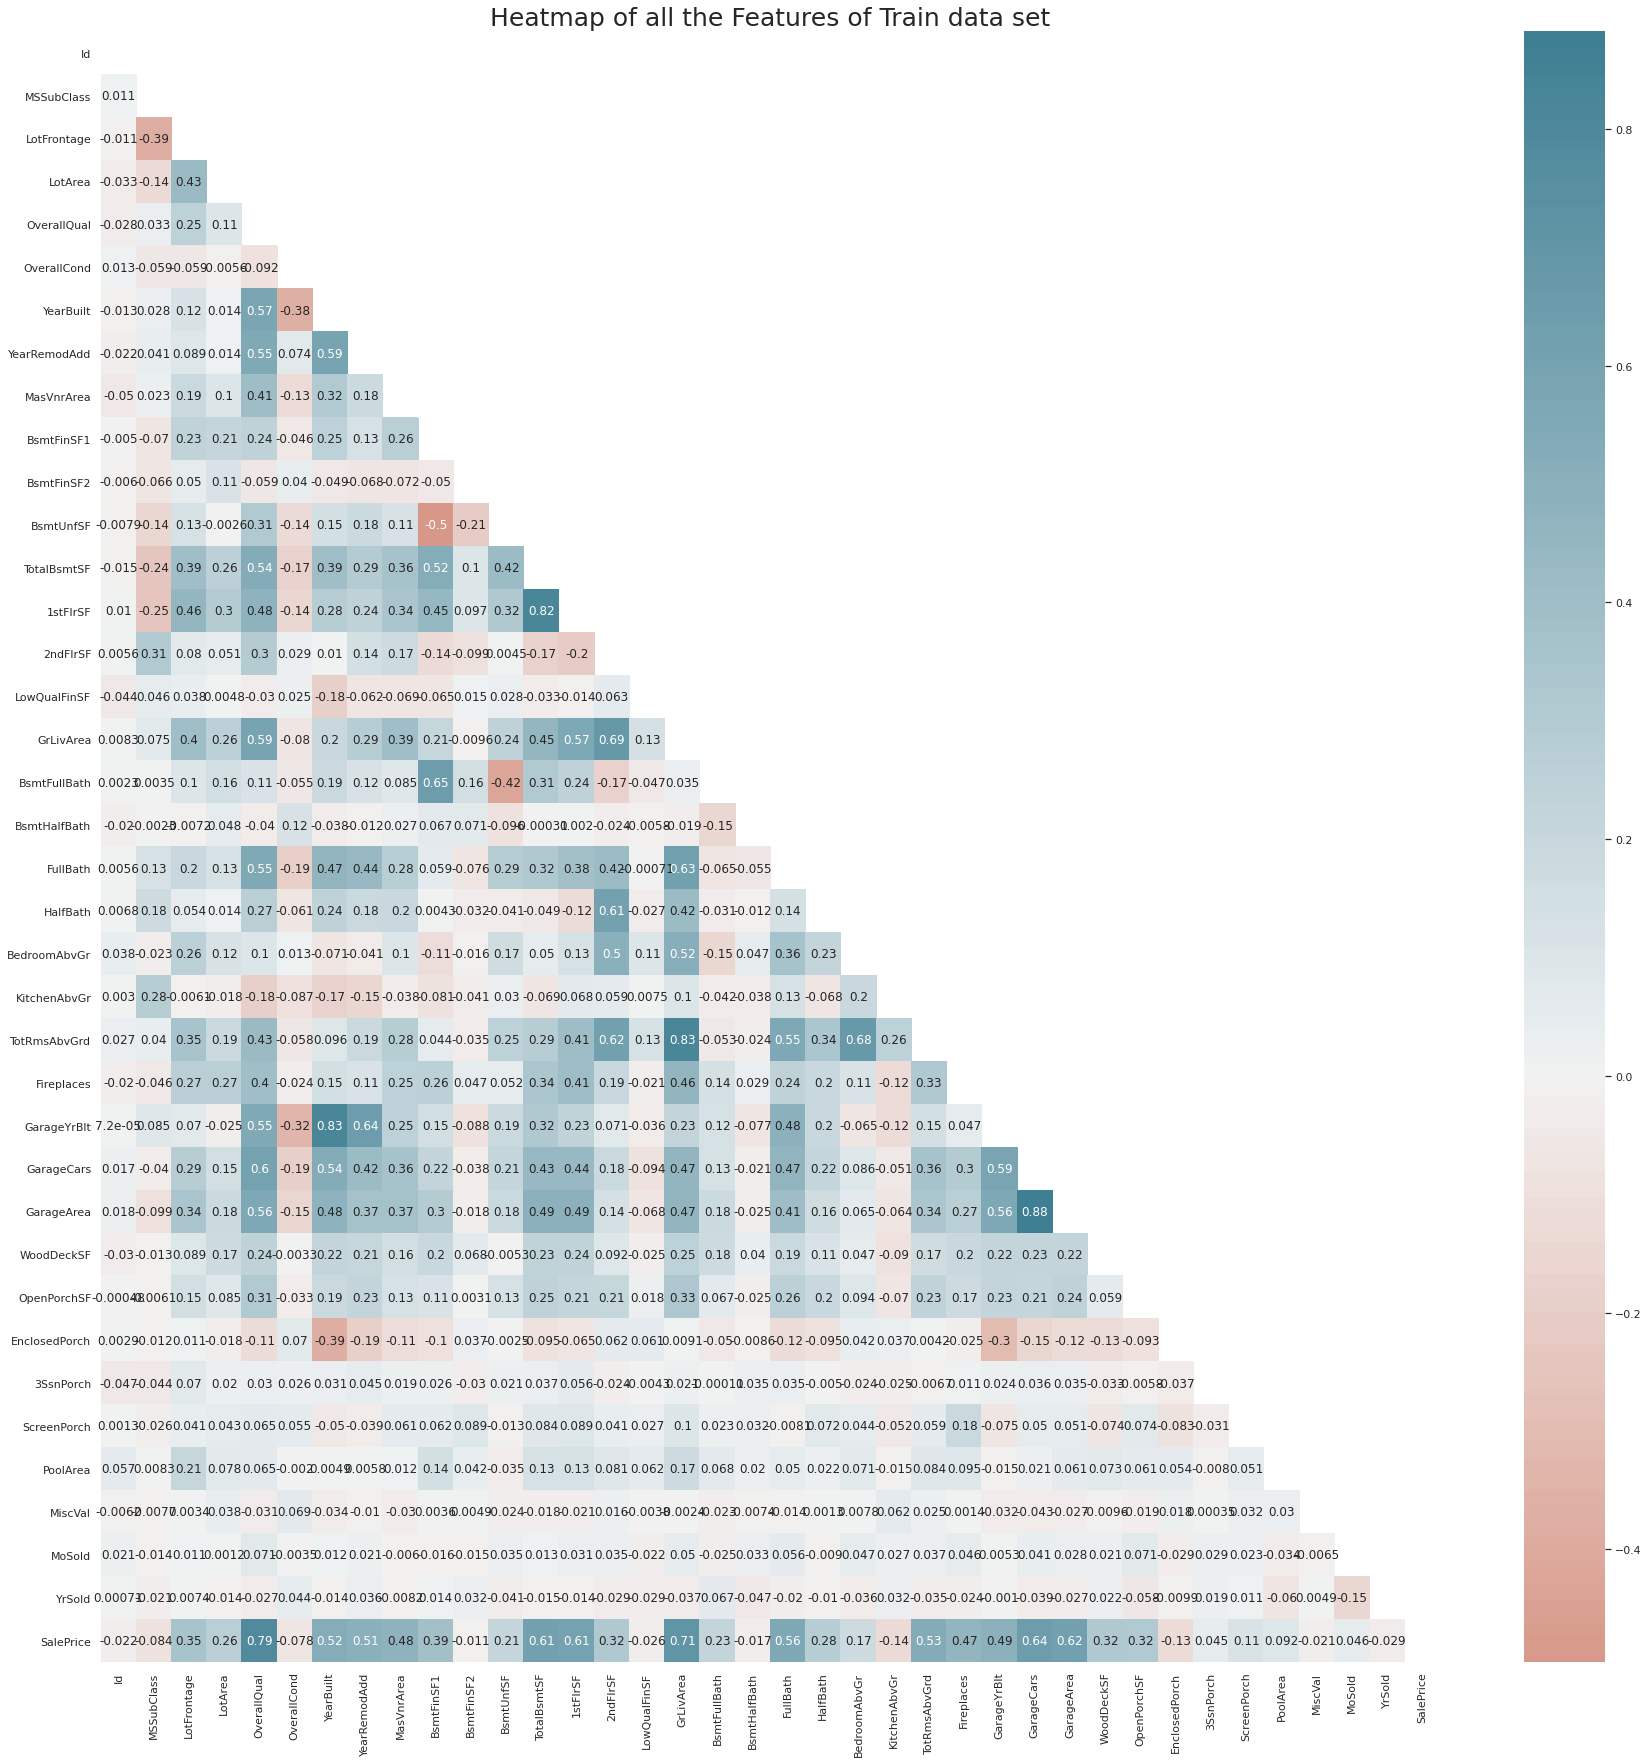

In [13]:
plt.subplots(figsize = (30,30))

## Plotting heatmap. Generate a mask for the lower triangle (taken from seaborn example gallery)
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

We can see from these observations that the SALEPRICE seem to be strongly-POSITIVE correlated to:

* OverallQual: 0.790982
* GrLivArea: 0.708624
* GarageCars: 0.640409
* GarageArea: 0.623431
* TotalBsmtSF: 0.613581

Which means that as one variable increases, the SalePrice value also increases. We will stop here and select these variables to analyse, eventhough there are probably other variable that should be considered in deep.

### SalePrice vs OverallQual

Overall material and finish quality

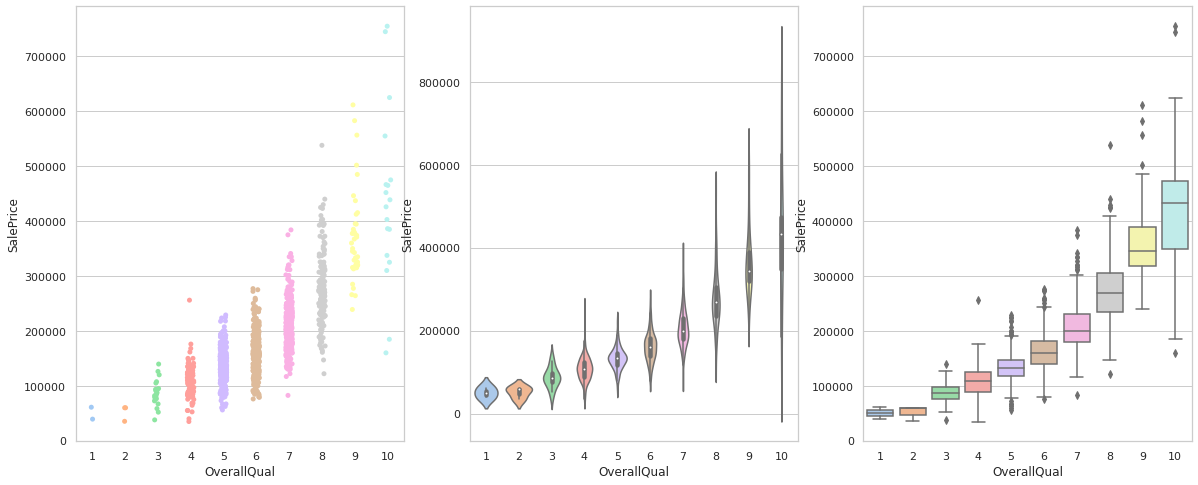

In [14]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

There is an apparent relationship between the two features. The price of the houses increases with the overall quality. Let's check out some more features to determine the outliers. Let's focus on the numerical variables this time.

### SalePrice vs GrLivArea

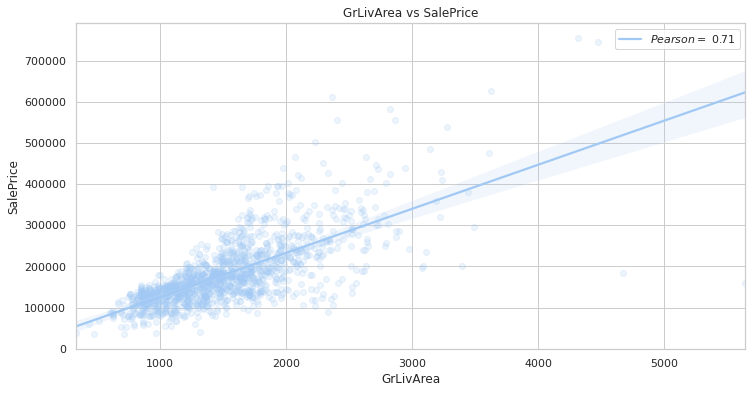

In [15]:
Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=train_df, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

As you can see, there are two outliers in the plot above. We will get rid off them later. Let's look at another scatter plot with a different feature.

### SalePrice vs GarageCars

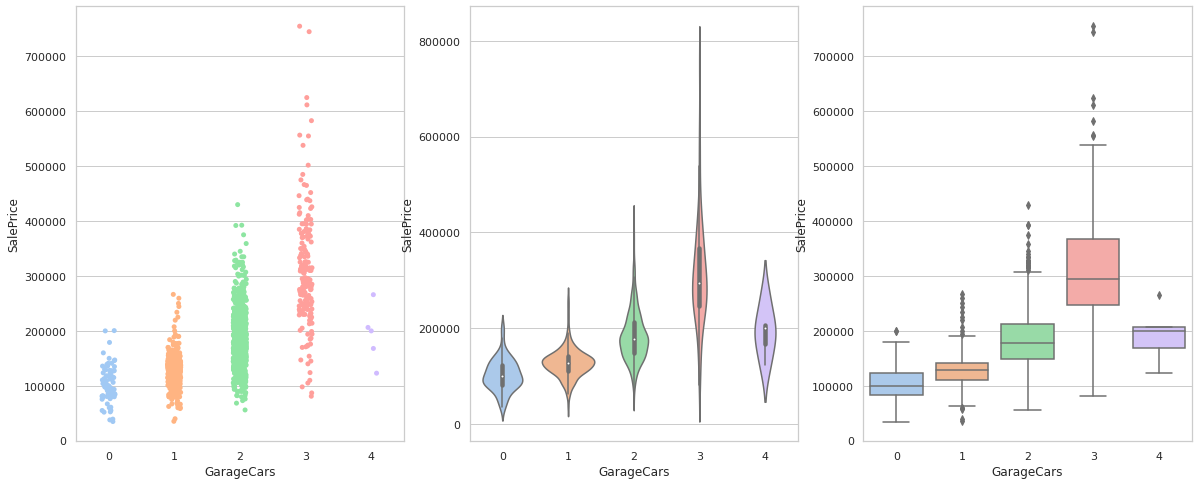

In [16]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_df, x = 'GarageCars', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_df, x = 'GarageCars', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_df, x = 'GarageCars', y='SalePrice', ax = ax[2])
plt.show()

### SalePrice vs GarageArea

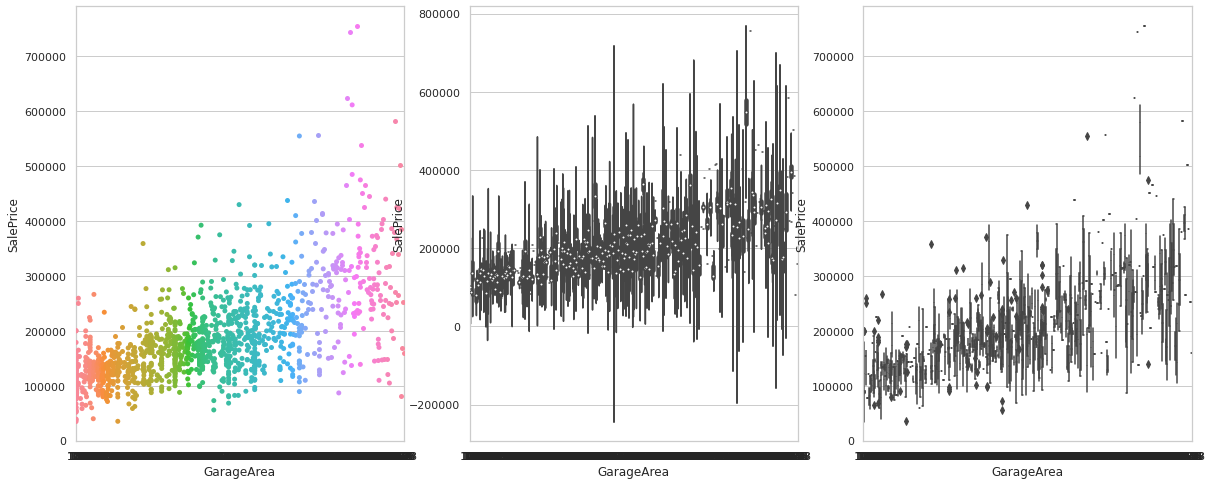

In [17]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_df, x = 'GarageArea', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_df, x = 'GarageArea', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_df, x = 'GarageArea', y='SalePrice', ax = ax[2])
plt.show()

### SalePrice vs TotalBcmtSF

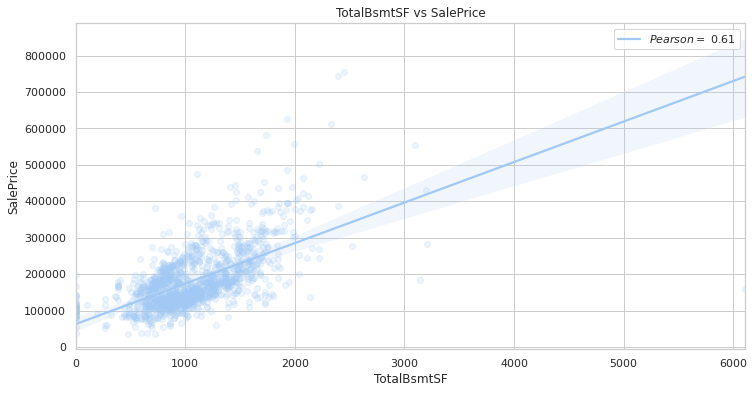

In [18]:
Pearson_TBSF = 0.61
plt.figure(figsize = (12,6))
sns.regplot(data=train_df, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')
plt.show()

<a id="t4."></a>
## 4. Feature Engineering

Now that we have some insights about data, we need to preprocess them for the modeling part. The main steps are:

* Looking at potential NaN
* Dealing with categorical features (e.g. Dummy coding)
* Normalization

Note from @marto24:
Usually, in a real-world project, the test data are not available until the end. For this reason, test data should contain the same type of data of the training set to preprocess them in the same way. Here, the test set is available. In this case, the creation of dummy variables has risen several issues when trying to make predictions on the test set, the easiest way to solve this problem is to concatenate Train and Test sets, preprocess, and divide them again.

In [19]:
# first we will make copies of our original datasets
train = train_df.copy()
test = test_df.copy()

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Separate Target and Features

In [21]:
target = train['SalePrice']
test_id = test['Id']
test = test.drop(['Id'],axis = 1)
train_final = train.drop(['Id'], axis = 1)

# Concatenating train & test set
train_test = pd.concat([train_final,test], axis=0, sort=False)

### Dropping Features Pipeline

In [22]:
# variable containing the columns that we want to remove
cols_missing_data = ['Alley','PoolQC', 'Fence', 'MiscFeature', 'Id']

# drop columns
train = train.drop(cols_missing_data, axis=1)
test = test.drop(cols_missing_data, axis=1)

KeyError: "['Id'] not found in axis"

### Numerical Attributes Pipeline

* Missing Data
* Scaler
* Skewness

To get our dataset ready for our ML algorithms, we need to deal with the missing data (replacing all NAs with the mean value) and scale our data, since ML algorithms are highly sensitive to features that span varying degrees of magnitude, range and units. Finally, we will need to deal with skewness. Skewness is the distortion of data from normality. It may act as outliers and produce unreliable results. The skewed data must be transformed back to normal distribution.

In [ ]:
num_attribs = train.select_dtypes(include=['int64', 'float64']).columns
num_attribs

In [ ]:
feature_skew = train.select_dtypes(include=[np.number]).skew()
log_attribs = feature_skew[abs(feature_skew) > 0.9].index
scale_attribs = [name for name in feature_skew.index if name not in log_attribs]

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

log_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('log', FunctionTransformer(np.log1p, validate=False)),
    ])

scale_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler()),
    ])

### Full Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer(transformers=[
        ("log", log_pipeline, log_attribs),
        ("scale", scale_pipeline, scale_attribs),
    ])

In [ ]:
X = preprocess_pipeline.fit_transform(train)
X

In [ ]:
X.shape

In [ ]:
y = target

### Train-Test Split
* X_train, y_train first used to train the algorithm.
* then, X_test is used in that trained algorithms to predict outcomes.
* Once we get the outcomes, we compare it with y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=64)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

<a id="t5."></a>
## 5. Shortlisting Promising ML Models

To model this data we will start by using a Linear Regression model.

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()

lm.fit(X_train,y_train)
y_pred_train=lm.predict(X_train)
y_pred_test=lm.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test))))

<a id="t6."></a>
## 6. Fine-Tune the Model

### Regularization Models

What makes regression model more effective is its ability of regularizing. The term "regularizing" stands for models ability to structurally prevent overfitting by imposing a penalty on the coefficients.

There are three types of regularizations.

* Ridge
* Lasso
* Elastic Net

These regularization methods work by penalizing the magnitude of the coefficients of features and at the same time minimizing the error between the predicted value and actual observed values. 

The only difference between Ridge and Lasso is the way they penalize the coefficients. Elastic Net is the combination of these two. Elastic Net adds both the sum of the squares errors and the absolute value of the squared error.

#### Ridge

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

lm_ridge=Ridge()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1]]}

lm_ridge=GridSearchCV(lm_ridge, param_grid=parameters)
lm_ridge.fit(X_train,y_train)
print("The best value of Alpha is: ",lm_ridge.best_params_,lm_ridge.best_score_)

In [ ]:
lm_ridge_mod=Ridge(alpha=1)
lm_ridge_mod.fit(X_train,y_train)
y_pred_train=lm_ridge_mod.predict(X_train)
y_pred_test=lm_ridge_mod.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test)))) 

#### Lasso

In [ ]:
from sklearn.linear_model import Lasso

lm_lasso =Lasso()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1]]}

lm_lasso=GridSearchCV(lm_lasso, param_grid=parameters)
lm_lasso.fit(X_train,y_train)
print("The best value of Alpha is: ",lm_lasso.best_params_,lm_lasso.best_score_)

In [ ]:
lm_lasso_mod =Lasso(alpha=0.0005)
lm_lasso_mod.fit(X_train,y_train)
y_pred_train=lm_lasso_mod.predict(X_train)
y_pred_test=lm_lasso_mod.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test)))) 

#### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

lm_elastic = ElasticNet()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1]]}

lm_elastic = GridSearchCV(lm_elastic, param_grid=parameters)
lm_elastic.fit(X_train,y_train)
print("The best value of Alpha is: ",lm_elastic.best_params_,lm_elastic.best_score_)

In [ ]:
lm_elastic_mod = ElasticNet(alpha=0.0005)
lm_elastic_mod.fit(X_train,y_train)
y_pred_train=lm_elastic_mod.predict(X_train)
y_pred_test=lm_elastic_mod.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Looking at the obtained results, the model giving us better results is the lasso model using an alpha = 0.0005 as the parameter.

<a id="t7."></a>
## 7. Presenting the Solution

### Preprocess the test_df

In [ ]:
test.shape

In [ ]:
final_test = preprocess_pipeline.fit_transform(test)
final_test

In [ ]:
final_test.shape

### Predict

In [ ]:
preds = lm_lasso_mod.predict(final_test)
preds = np.exp(preds)

### Model Result Submission

In [ ]:
my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': preds})

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv("lao_sol.csv", index = False)